In [1]:
# Import Modules
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dask.distributed import Client, progress
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from dask_ml.model_selection import train_test_split
import time


/Users/jintanoda/Desktop/Big-Data/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ImportError: Dask dataframe requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[dataframe]" --upgrade  # or python -m pip install

In [31]:
# Specify Data Types of Columns
col_type = {
    'Level': 'str',
    'Date': 'str',
    'State FIPS': 'str',
    'State Postal Code': 'str',
    'County FIPS': 'str',
    'County Name': 'str',
    'Population Staying at Home': 'float64',
    'Population Not Staying at Home': 'float64',
    'Number of Trips': 'float64',
    'Number of Trips <1': 'float64',
    'Number of Trips 1-3': 'float64',
    'Number of Trips 3-5': 'float64',
    'Number of Trips 5-10': 'float64',
    'Number of Trips 10-25': 'float64',
    'Number of Trips 25-50': 'float64',
    'Number of Trips 50-100': 'float64',
    'Number of Trips 100-250': 'float64',
    'Number of Trips 250-500': 'float64',
    'Number of Trips >=500': 'float64',
    'Row ID': 'str',
    'Week': 'int64',
    'Month': 'int64'
}

# Loading datasets to dataframes
trips_by_distance = pd.read_csv("Trips_by_Distance.csv")
trips_full = pd.read_csv("Trips_Full Data.csv")
trips_by_distance_dask = dd.read_csv("Trips_by_Distance.csv", blocksize="20MB", dtype=col_type)

In [32]:
# Data cleaning
def clean_dateframe(df , df_type):
    if df_type == "pd":
        # Remove rows with any empty cells
        df.dropna(inplace=True)
        # Remove duplicates
        df.drop_duplicates(keep="first", inplace=True)
        # Remove columns cotaining only Na
        df.dropna(axis="columns", how="all", inplace=True)
    elif df_type == "dd":
        df = df.dropna()
        df = df.drop_duplicates(keep="first")
        df = df.map_partitions(lambda df: df.dropna(axis='columns', how='all'), meta=df)
    else:
        return "Invalid dataframe type"
    
    return df


def convert_to_date(df, df_type):
    if df_type == "pd":
        df["Date"] = pd.to_datetime(df['Date'], errors='coerce')
    elif df_type == "dd":
        df["Date"] = dd.to_datetime(df["Date"], errors='coerce')
    else:
        return ("Invalid dateframe type")
    
    df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')
    return df
 
trips_by_distance = clean_dateframe(trips_by_distance, "pd")
trips_full = clean_dateframe(trips_full, "pd")
trips_by_distance_dask = clean_dateframe(trips_by_distance_dask, "dd")

trips_by_distance = convert_to_date(trips_by_distance, "pd")
trips_full = convert_to_date(trips_full, "pd")
trips_by_distance_dask = convert_to_date(trips_by_distance_dask, "dd")

In [33]:
print(len(trips_by_distance))
print(len(trips_by_distance_dask))

988773
988773


In [44]:
# Data Processing
def data_processing(df):
    # show types of columns
    print(f"Types of columns:\n{df.dtypes}")
    # count non-null
    print(f"Number of null: {df.isna().sum()}")
    # compute descriptive statistics for the whole dataframe
    print(df.describe())

data_processing(trips_by_distance)
data_processing(trips_full)


Types of columns:
Level                              object
Date                               object
State FIPS                        float64
State Postal Code                  object
County FIPS                       float64
County Name                        object
Population Staying at Home        float64
Population Not Staying at Home    float64
Number of Trips                   float64
Number of Trips <1                float64
Number of Trips 1-3               float64
Number of Trips 3-5               float64
Number of Trips 5-10              float64
Number of Trips 10-25             float64
Number of Trips 25-50             float64
Number of Trips 50-100            float64
Number of Trips 100-250           float64
Number of Trips 250-500           float64
Number of Trips >=500             float64
Row ID                             object
Week                                int64
Month                               int64
dtype: object
Number of null: Level                       

In [46]:
# Data categorization

# Count the unique values for the "week" column 
print(trips_by_distance['Week'].nunique())
# Group the average Population Staying at Home per week
print(trips_by_distance.groupby(by = 'Week')['Population Staying at Home'].mean())

45
Week
0     20976.786952
1     20071.310863
2     19897.342408
3     19889.436675
4     20096.313462
5     19757.425989
6     19599.069548
7     20033.597170
8     19741.670867
9     20043.095149
10    19826.900589
11    20264.390629
12    20632.226251
13    20792.383279
14    21064.024586
15    21375.296433
16    20066.291118
17    19666.744804
18    20020.237718
19    19679.550872
20    19881.386992
21    20060.819541
22    19897.745108
23    20503.628696
24    20571.770526
25    20088.389972
26    20823.985153
27    20249.929104
28    20038.482247
29    20758.966759
30    20662.342080
31    20285.019485
32    19052.686234
33    18745.051412
34    18890.033421
35    20627.338011
36    19918.284514
37    20077.207573
38    20648.268011
39    21323.439768
40    21132.913589
41    21656.941398
42    21958.423366
43    21998.566027
44     7465.212121
Name: Population Staying at Home, dtype: float64


Number of weeks 45


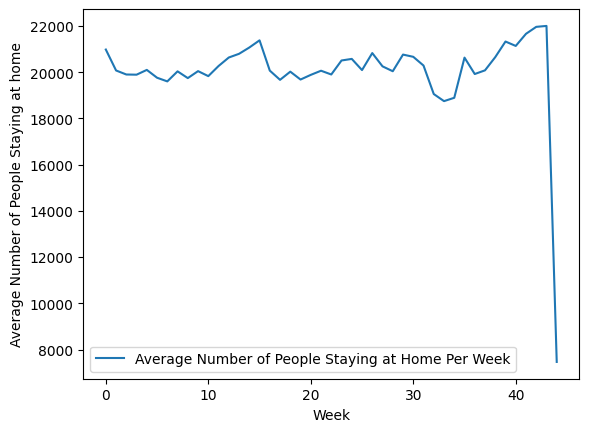

In [35]:
# Question 1 (a)
def plot_avg_people_staying_home(df, df_type):
    # Average number of people staying at home over the week
    weeks = df["Week"].nunique()
    avg_num_people_staying_home = df.groupby(by="Week")["Population Staying at Home"].mean()

    if df_type == 'pd':
        print(f"Number of weeks {weeks}")
        # Plot 'Average Number of People Staying at Home Per Week'
        plt.plot(avg_num_people_staying_home, label='Average Number of People Staying at Home Per Week')
        

    elif df_type == 'dd':
        print(f"Number of weeks {weeks.compute()}")
        plt.plot(avg_num_people_staying_home.compute(), label='Average Number of People Staying at Home Per Week')

    else:
        return "Invalid dataframe type"
    
    plt.xlabel('Week')
    plt.ylabel('Average Number of People Staying at home')
    plt.legend()
    plt.show()
    plt.close()

plot_avg_people_staying_home(trips_by_distance, "pd")

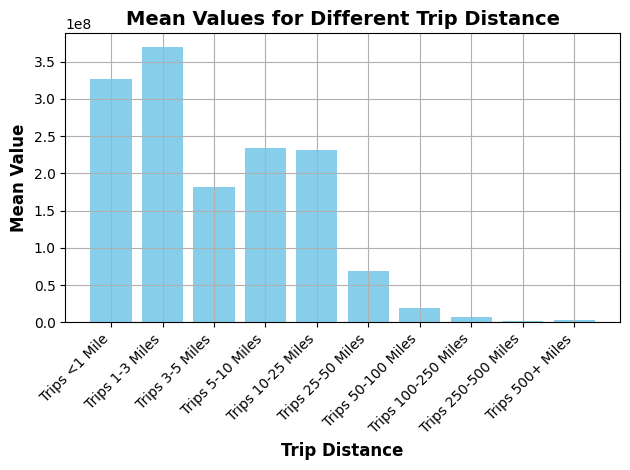

In [36]:
# Question 1 (a)
# How far people are traveling
def plot_how_far_people_travel():
    cols = [
        'Trips <1 Mile',
        'Trips 1-3 Miles',
        'Trips 3-5 Miles',
        'Trips 5-10 Miles',
        'Trips 10-25 Miles',
        'Trips 25-50 Miles',
        'Trips 50-100 Miles',
        'Trips 100-250 Miles',
        'Trips 250-500 Miles',
        'Trips 500+ Miles'
    ]

    means = []
    for i in range(len(cols)):
        mean = trips_full.groupby(by = 'Week of Date')[cols[i]].mean()
        means.append(mean.values[0])

    # Bar 'Mean Values for Different Trip Distance'
    plt.bar(cols, means, color='skyblue')
    plt.title('Mean Values for Different Trip Distance', fontsize=14, fontweight='bold')
    plt.xlabel('Trip Distance', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Value', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()      
    plt.close()

plot_how_far_people_travel()

In [37]:
# (b)
def plot_compare_dates(df, df_type):
    trips_10_25_by_date = df.groupby(by="Date")['Number of Trips 10-25'].sum() # total number of people who conducted 10-25 Number of Trips by dates
    dates_more_than_10m_trips_a = trips_10_25_by_date[trips_10_25_by_date > 10000000]

    trips_50_100_by_date = df.groupby(by="Date")['Number of Trips 50-100'].sum() # total number of people who conducted 10-25 Number of Trips by dates
    dates_more_than_10m_trips_b = trips_50_100_by_date[trips_50_100_by_date > 10000000]

    if df_type == 'pd':
        print(f"Dates pepople conducted 10-25 number of trips {dates_more_than_10m_trips_a.index}") # dates more than 10000000 people conducted 10-25 Number of Trips
        print(f"Dates pepople conducted 50-100 number of trips {dates_more_than_10m_trips_b.index}") # dates more than 10000000 people conducted 50-100 Number of Trips

        # scatter plot (dates vs number of people who conducted 10-25 Number of Trips)
        fig = px.scatter(x=dates_more_than_10m_trips_a.index, y=dates_more_than_10m_trips_a.values)
        fig.update_layout(
            xaxis_title="Date",
            yaxis_title="Number of Trips",
            title="Dates vs More Than 10 Million People Conducted 10-25 Number of Trips"
        )
        fig.show()

        # scatter plot (dates vs number of people who conducted 50-100 Number of Trips)
        fig = px.scatter(x=dates_more_than_10m_trips_b.index, y=dates_more_than_10m_trips_b.values)
        fig.update_layout(
            xaxis_title="Date",
            yaxis_title="Number of Trips",
            title="Dates vs More Than 10 Million People Conducted 50-100 Number of Trips"
        )
        fig.show()

    elif df_type == 'dd':
        print(f"Dates pepople conducted 10-25 number of trips {dates_more_than_10m_trips_a.index.compute()}") # dates more than 10000000 people conducted 10-25 Number of Trips
        print(f"Dates pepople conducted 50-100 number of trips {dates_more_than_10m_trips_b.index.compute()}") # dates more than 10000000 people conducted 50-100 Number of Trips

        # scatter plot (dates vs number of people who conducted 10-25 Number of Trips)
        fig = px.scatter(x=dates_more_than_10m_trips_a.index.compute(), y=dates_more_than_10m_trips_a.values.compute())
        fig.update_layout(
            xaxis_title="Date",
            yaxis_title="Number of Trips",
            title="Dates vs More Than 10 Million People Conducted 10-25 Number of Trips"
        )
        fig.show()

        # scatter plot (dates vs number of people who conducted 50-100 Number of Trips)
        fig = px.scatter(x=dates_more_than_10m_trips_b.index.compute(), y=dates_more_than_10m_trips_b.values.compute())
        fig.update_layout(
            xaxis_title="Date",
            yaxis_title="Number of Trips",
            title="Dates vs More Than 10 Million People Conducted 50-100 Number of Trips"
        )
        fig.show()
    
    else:
        return "Invalid dataframe type"

plot_compare_dates(trips_by_distance, "pd")

Dates pepople conducted 10-25 number of trips Index(['01/01/2019', '01/02/2019', '01/03/2019', '01/04/2019', '01/05/2019',
       '01/06/2019', '01/07/2019', '01/08/2019', '01/09/2019', '01/10/2019',
       ...
       '10/23/2019', '10/24/2019', '10/25/2019', '10/26/2019', '10/27/2019',
       '10/28/2019', '10/29/2019', '10/30/2019', '10/31/2019', '11/01/2019'],
      dtype='object', name='Date', length=319)
Dates pepople conducted 50-100 number of trips Index(['01/01/2019', '01/02/2019', '01/03/2019', '01/04/2019', '01/05/2019',
       '01/06/2019', '01/07/2019', '01/08/2019', '01/09/2019', '01/10/2019',
       ...
       '10/22/2019', '10/23/2019', '10/24/2019', '10/25/2019', '10/26/2019',
       '10/27/2019', '10/28/2019', '10/29/2019', '10/30/2019', '10/31/2019'],
      dtype='object', name='Date', length=318)





Starting computation with 3 processors...





/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57513 instead



Number of weeks 45


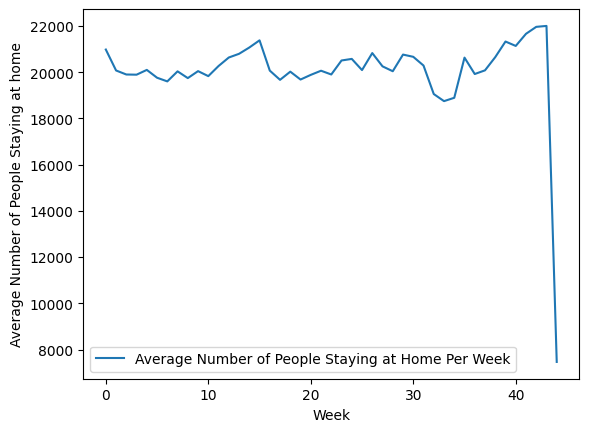

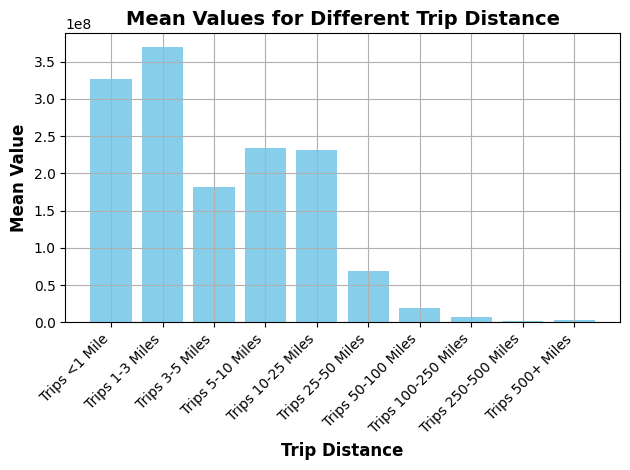

Dates pepople conducted 10-25 number of trips Index(['01/01/2019', '01/02/2019', '01/03/2019', '01/04/2019', '01/05/2019',
       '01/06/2019', '01/07/2019', '01/08/2019', '01/09/2019', '01/10/2019',
       ...
       '10/23/2019', '10/24/2019', '10/25/2019', '10/26/2019', '10/27/2019',
       '10/28/2019', '10/29/2019', '10/30/2019', '10/31/2019', '11/01/2019'],
      dtype='string', name='Date', length=319)
Dates pepople conducted 50-100 number of trips Index(['01/01/2019', '01/02/2019', '01/03/2019', '01/04/2019', '01/05/2019',
       '01/06/2019', '01/07/2019', '01/08/2019', '01/09/2019', '01/10/2019',
       ...
       '10/22/2019', '10/23/2019', '10/24/2019', '10/25/2019', '10/26/2019',
       '10/27/2019', '10/28/2019', '10/29/2019', '10/30/2019', '10/31/2019'],
      dtype='string', name='Date', length=318)





Time with 3 processors: 430.64589190483093 seconds






Starting computation with 4 processors...





/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57615 instead



KeyboardInterrupt: 

2024-04-07 22:44:07,634 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 9 memory: 12 MB fds: 26>>
Traceback (most recent call last):
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/psutil/__init__.py", line 2166, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


In [95]:
# (c)
def processor_time():
    n_processors = [10, 20]
    n_processors_time = {}
   
    for processor in n_processors:
        print(f"\n\n\nStarting computation with {processor} processors...\n\n\n")
        client = Client(n_workers = processor)
        start = time.time()

        # (a) with dask
        plot_avg_people_staying_home(trips_by_distance_dask, "dd")
        plot_how_far_people_travel()
        # (b) with dask
        plot_compare_dates(trips_by_distance_dask, "dd")

        dask_time = time.time() - start
        n_processors_time[processor] = dask_time

        print(f"\n\n\nTime with {processor} processors: {dask_time} seconds\n\n\n")
        client.close()
    print("\n\n\n", n_processors_time, "\n\n\n")

processor_time()

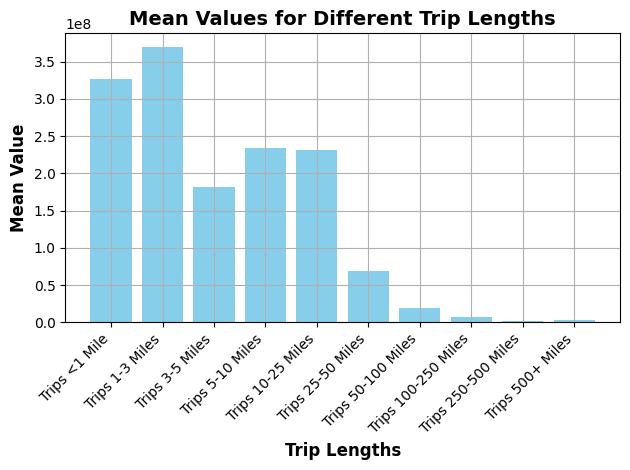

2024-04-07 15:31:27,361 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 1 memory: 15 MB fds: 26>>
Traceback (most recent call last):
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/jintanoda/Desktop/5011CEM-Big-Data/venv/lib/python3.10/site-packages/psutil/__init__.py", line 2166, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


In [65]:
# (e)
trips_full['Week of Date'].nunique()

cols = [
    'Trips <1 Mile',
    'Trips 1-3 Miles',
    'Trips 3-5 Miles',
    'Trips 5-10 Miles',
    'Trips 10-25 Miles',
    'Trips 25-50 Miles',
    'Trips 50-100 Miles',
    'Trips 100-250 Miles',
    'Trips 250-500 Miles',
    'Trips 500+ Miles'
]

means = []
for i in range(len(cols)):
    temp = trips_full.groupby(by = 'Week of Date')[cols[i]].mean()
    means.append(temp.values[0])

plt.bar(cols, means, color='skyblue')
plt.title('Mean Values for Different Trip Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Trip Lengths', fontsize=12, fontweight='bold')
plt.ylabel('Mean Value', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()      
plt.close()

In [22]:
# (d)
def linear_model(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"coefficient of determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"coefficients: {model.coef_}")
    # Model to predict the response
    y_pred = model.predict(x)
    print(f"predicted response:\n{y_pred}")

def model_training(x,y):
    X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=False)
    model = RandomForestClassifier(verbose=1)
    print(f"X_train: {X_train}")
    print(f"X_test: {X_test}")
    print(model.fit(X_train, y_train))
    predictions = model.predict(X_test)
    print(f"prediction: {predictions}")

columns = [
    'Number of Trips <1',
    'Number of Trips 1-3', 
    'Number of Trips 3-5', 
    'Number of Trips 5-10',
    'Number of Trips 10-25', 
    'Number of Trips 25-50', 
    'Number of Trips 50-100',
    'Number of Trips 100-250', 
    'Number of Trips 250-500', 
    'Number of Trips >=500'
]

trips_by_distance['Date'] = pd.to_datetime(trips_by_distance['Date'], format='%m/%d/%Y')
# week 32 dataframe with columns of number of trips
df_week32 = trips_by_distance[(trips_by_distance['Week'] == 32) & (trips_by_distance['Date'].dt.year == 2019)][columns]
# Model selection
# Predictor variable: length of trip (10-25 Miles)
x = trips_full.loc[:,"Trips 50-100 Miles"]
x = np.array(x).reshape((-1, 1))
# Predicted variable: frequency of people to travel
y = df_week32.loc[:,"Number of Trips 50-100"]
y = np.array(y)[:len(x)]

linear_model(x, y)
model_training(x, y)

coefficient of determination: 0.3093006198654834
intercept: -13449.502049671624
coefficients: [0.00092087]
predicted response:
[4886.82498269 2960.00997896 2620.07870572 2959.51731292 2637.2354549
 5421.97263813 6059.36092668]
X_train: [[19911937]
 [17819554]
 [17450413]
 [17819019]
 [17469044]
 [20493069]]
X_test: [[21185227]]
RandomForestClassifier(verbose=1)
prediction: [5950.]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [17]:
x

array([[19911937],
       [17819554],
       [17450413],
       [17819019],
       [17469044],
       [20493069],
       [21185227]])

In [18]:
y

array([2148., 2109., 1418., 7083., 1721., 5950., 7116.])